*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  20.09.2024

--- 
# Plot total vehicle kilometers travelled and their share across different traffic situations

<!--Notebook description and usage information-->
A primary result of the model is an estimate of the vehicle kilometers traveled (VKT) for different vehicle classes and the respective traffic conditions. This script uses the coutning data and traffic model to calculate the total annual VKT and share of traffic conditions in the timeframe of interest. 

In [1]:
# import libraries

import sys
import warnings
import os
os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime

sys.path.append('../utils')
import data_paths
from traffic_counts import TrafficCounts
from hbefa_hot_emissions import HbefaHotEmissions
from calculate_vkt import calculate_VKT

warnings.filterwarnings("ignore")

# Reload local modules on changes
%reload_ext autoreload
%autoreload 2

# Notebook settings

In [2]:
# Define start and end time for emission calculation. Ideally this should cover a whole year.
start_date = datetime(2019, 1, 1)
end_date = datetime(2024, 12, 31)

# define filename of the visum file
visum_filename = "visum_links.GPKG"

# if True, the script will only calculate the emission for the area within the roi polygon
clip_to_area = True
roi_polygon = data_paths.MUNICH_BOARDERS_FILE # defines ROI for clipping

## Import Data

In [3]:
# import visum model, clip it to the ROI, and initialize cycles object

visum = gpd.read_file(data_paths.VISUM_FOLDER_PATH + visum_filename)

if clip_to_area:
    roi = gpd.read_file(roi_polygon).to_crs(visum.crs)
    visum = gpd.clip(visum, roi)
    visum = visum.explode(ignore_index=True) # convert multipolygons to polygons

#visum = visum_links
visum = visum.reset_index(drop = True).reset_index() # reset index for calculation
visum['road_lenght'] = visum['geometry'].length # add road length to visum dict

# initialize traffic cycles
cycles = TrafficCounts()
# initialize HBEFA emission factors
hbefa = HbefaHotEmissions()

Loaded emission factors from /Users/daniel_tum/Documents/code/drive-inventory/data/restricted_input/hbefa/EFA_HOT_ts_hbefa.txt
Loaded emission factors from /Users/daniel_tum/Documents/code/drive-inventory/data/restricted_input/hbefa/EFA_HOT_aggregated_hbefa.txt


## Calculate VKT and traffic condition

In [4]:
# Calculate VKT per year and traffic condition for each vehicle class

vkt_result = dict()

# create list of dates
dates = [d.strftime("%Y-%m-%d") for d in pd.date_range(start=start_date, end=end_date, freq='1d')]
# extract list of years in dates list
years = list(set([d.split('-')[0] for d in dates]))
years.sort()

# sort dates by year
for year in years:
    # create sublist of dates for each year
    dates_in_year = [d for d in dates if d.startswith(year)]

    final_result = {'Freeflow': np.array(5, float),
                    'Heavy': np.array(5, float),
                    'Satur.': np.array(5, float),
                    'St+Go': np.array(5, float), 
                    'St+Go2': np.array(5, float)}
    
    # calculate for each date in the year
    for date in dates_in_year: 
        cl, vehicle_index = calculate_VKT(date= date,
                                          visum_dict=visum.to_dict('records'),
                                          cycles_obj = cycles,
                                          hbefa_obj = hbefa)
        
        for key, value in cl.items():
            final_result[key] = final_result[key] + value
    vkt_result.update({year:final_result})

In [5]:
# calculate total vehicle kilometers by vehicle class

total_vkt = pd.DataFrame()
for key, item in vkt_result.items(): 
    df = pd.DataFrame(data = item, index = vehicle_index).sum(axis =1)
    df.name = key
    total_vkt = pd.concat([total_vkt, df], axis = 1)

total_vkt = total_vkt.transpose()
total_vkt = total_vkt[['PC', 'LCV', 'HGV', 'BUS', 'MOT']]
total_vkt

,PC,LCV,HGV,BUS,MOT
2019,4.927981e+09,8.184413e+08,2.851454e+08,3.529077e+07,6.006421e+07
2020,4.195718e+09,8.274179e+08,2.348416e+08,2.944693e+07,5.761876e+07
2021,4.236222e+09,8.970469e+08,2.134531e+08,2.880707e+07,5.299776e+07
2022,4.444618e+09,8.947707e+08,2.201433e+08,3.141659e+07,5.998107e+07
2023,4.526205e+09,9.279806e+08,2.144002e+08,2.951184e+07,5.840325e+07
2024,4.653137e+09,8.453285e+08,2.055204e+08,2.902762e+07,5.574624e+07


In [6]:
# Calculate share of total VKT for each traffic condition 

los_class_vkt = pd.DataFrame()
for key, item in vkt_result.items(): 
    df = pd.DataFrame(data=item, index = vehicle_index).sum(axis = 0)
    df.name = key
    los_class_vkt = pd.concat([los_class_vkt, df], axis = 1)

los_class_vkt = los_class_vkt.transpose() 

los_class_vkt = los_class_vkt.divide(los_class_vkt.sum(axis=1), axis =0)
los_class_vkt

,Freeflow,Heavy,Satur.,St+Go,St+Go2
2019,0.533783,0.225212,0.162909,0.055798,0.022297
2020,0.588716,0.220875,0.146775,0.030905,0.012730
2021,0.584563,0.225211,0.149318,0.029028,0.011880
2022,0.583236,0.223420,0.152926,0.029337,0.011081
2023,0.572146,0.220942,0.160506,0.033627,0.012779
2024,0.576938,0.218946,0.161580,0.031706,0.010829


# Plotting

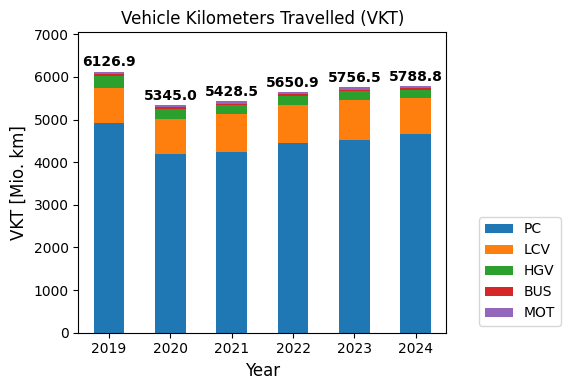

In [7]:
fig, ax = plt.subplots(figsize =(6,4), tight_layout =True)

total_vkt.plot(ax = ax, kind='bar', stacked = True)

plt.title('Vehicle Kilometers Travelled (VKT)', fontsize = 12)

# add totals
y_offset = total_vkt.sum(axis=1).max()*0.02
for idx, year in enumerate(total_vkt.index):
    annual_vkt = total_vkt.loc[year].sum()
    ax.text(y = annual_vkt + y_offset,
            x= idx,
            s = f'{(annual_vkt*1e-6):.1f}',
            fontsize =10,
            weight='bold', 
            ha = 'center')

y_labels = ax.get_yticks()
y_labels = [f'{int(label)*1e-6:.0f}' for label in y_labels]
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation=0, fontsize = 10)
ax.set_yticklabels(labels = y_labels, fontsize= 10)
ax.set_ylabel('VKT [Mio. km]', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)

plt.legend(bbox_to_anchor =(1.2,0), loc = 'lower center', ncols=1, fontsize = 10)
plt.ylim(0, total_vkt.sum(axis=1).max()*1.15)
plt.show()

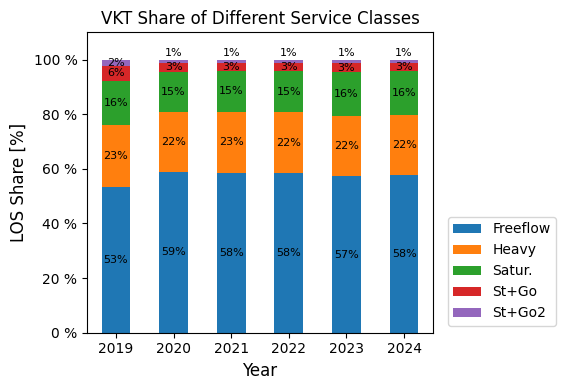

In [8]:
fig, ax = plt.subplots(figsize =(6,4), tight_layout =True)
los_class_vkt.plot(ax = ax, kind='bar', stacked = True)

y_labels = ax.get_yticks()
y_labels = [f'{label*1e2:.0f} %' for label in y_labels]
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation=0, fontsize = 10)
ax.set_yticklabels(labels = y_labels, fontsize= 10)
ax.set_ylabel('LOS Share [%]', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)

i = 0
for idx, row in los_class_vkt.iterrows():
    pos_y = 0
    for el in row:
        ax.text(y = pos_y +(el/2),
            x= i,
            s = f'{el*100:.0f}%',
            fontsize =8,
            ha = 'center',
            va = 'center', color = 'black')
        if (el)<0.05: 
            pos_y += (el + 0.03)
        else: 
            pos_y += el
    i+=1

plt.title('VKT Share of Different Service Classes', fontsize = 12)
plt.legend(bbox_to_anchor =(1.2,0), loc = 'lower center', ncols=1, fontsize = 10)
plt.ylim(0,1.1)
plt.show()